dropout: lựa chọn ngẫu nhiên 1 số unit của mỗi layer dừng hoạt động (=0) mã vẫn đảm bảo kì vọng ko đổi vd: 1 * x + 0 * x = 0.5 * 2x + 0.5 * 0
chỉ xảy ra trong lúc train, chạy bình thường cả mạng với lúc eval

**Một số lưu ý**
- Nên tăng dần xác suất dropout qua các lớp sâu hơn vì các lớp đầu tiên (gần input) chịu trách nhiệm trích xuất các đặc trưng cơ bản (như cạnh, góc trong ảnh). Nếu áp dụng dropout quá mạnh ($0.5$) ở ngay lớp đầu, nó phá hủy thông tin gốc quá nhiều trước khi mạng kịp học được gì.
- Có dropout ngăn chặn Overfitting, cho phép train lâu hơn để đạt điểm tổng quát hóa tốt hơn.
- Không dropout lúc eval vì
    + Nếu dùng dropout, cùng một ảnh đầu vào sẽ cho ra các kết quả khác nhau mỗi lần chạy. Thực tế kết quả phải nhất quán
    + kết quả trung bình của nhiều mô hình luôn tốt hơn hoặc bằng một mô hình đơn lẻ
- Weight Decay vs Dropout
    + Weight Decay ($L_2$ regularization): Cố gắng ép các giá trị trọng số $w$ nhỏ xuống gần 0. Nó hạn chế độ lớn của tham số.
    + Dropout: Cố gắng làm cho mạng không phụ thuộc vào bất kỳ nơ-ron cụ thể nào. Nó hạn chế cấu trúc của mạng.
    + Thông thường, chúng bổ trợ cho nhau rất tốt. Các mạng hiện đại (như ResNet, VGG) thường dùng cả hai (Weight decay nhẹ + Dropout).
    + Nếu dùng cả hai quá mạnh, chúng có thể gây ra Underfitting (Không học được gì).
- DropConnect: tắt ngẫu nhiên từng trọng số $w_{ij}$ thay vì tắt toàn bộ nơ-ron (activations). Tổng quát hóa tốt hơn trong CV nhưng phức tạp hơn -> Dropout phổ biến hơn


In [1]:
import torch
from torch import nn, optim


In [2]:

class MLP(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(num_hiddens, num_outputs)
        )

    def forward(self, X):
        return self.net(X)


In [3]:
import torchvision
from torchvision import transforms

trans = torchvision.transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

data_train = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=trans,
    download=True)
data_val = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=trans,
    download=True
)

len(data_train), len(data_val)

(60000, 10000)

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    data_train,
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    data_val,
    batch_size=64,
    shuffle=False
)

In [5]:
print(train_loader.dataset[0][0].shape)  # image
print(train_loader.dataset[0][1])        # label

torch.Size([1, 32, 32])
5


In [6]:
model = MLP(num_inputs=1024, num_hiddens=256, num_outputs=10, dropout=0.5)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(params=model.parameters(), lr=0.1, weight_decay=1e-4)

epochs = 20

loss_histoty = {"train": [], "val": []}

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        y_hat = model(X_batch)

        loss = criterion(y_hat, y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss += loss.item()
    train_loss_avg = train_loss / len(train_loader)
    loss_histoty["train"].append(train_loss_avg)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_hat = model(X_batch)
            loss = criterion(y_hat, y_batch)
            val_loss += loss.item()
        
        val_loss_avg = val_loss / len(val_loader)
        loss_histoty["val"].append(val_loss_avg)
    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss_avg}, Val Loss: {val_loss_avg}")



Epoch 1/20: Train Loss: 0.4848100368672215, Val Loss: 0.22996563903370482
Epoch 2/20: Train Loss: 0.25327610429018926, Val Loss: 0.1658739364545816
Epoch 3/20: Train Loss: 0.20002183211701258, Val Loss: 0.13725129590268917
Epoch 4/20: Train Loss: 0.17290002386421283, Val Loss: 0.11843315675219959
Epoch 5/20: Train Loss: 0.15571501866173643, Val Loss: 0.10722221314141847
Epoch 6/20: Train Loss: 0.1393689247888765, Val Loss: 0.09760330107943956
Epoch 7/20: Train Loss: 0.13096290169708702, Val Loss: 0.09039383595564646
Epoch 8/20: Train Loss: 0.118320576834685, Val Loss: 0.08583424095165246
Epoch 9/20: Train Loss: 0.11526407706720043, Val Loss: 0.08125200568717626
Epoch 10/20: Train Loss: 0.10871617486382694, Val Loss: 0.07865281419340628
Epoch 11/20: Train Loss: 0.10214352678718057, Val Loss: 0.07543899094690361
Epoch 12/20: Train Loss: 0.09939096207176444, Val Loss: 0.07410768416130346
Epoch 13/20: Train Loss: 0.09434370204373431, Val Loss: 0.0725187255369179
Epoch 14/20: Train Loss: 0.

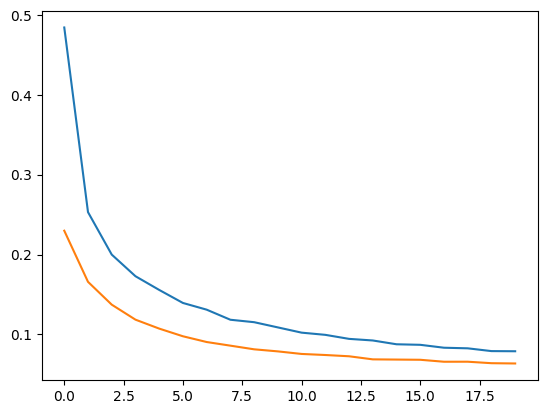

In [7]:
from matplotlib import pyplot as plt

plt.plot(loss_histoty["train"], label="train_loss")
plt.plot(loss_histoty["val"], label = "val_loss")

plt.show()

In [8]:
from sklearn.metrics import classification_report

# Tính toán predictions trên tất cả validation data
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        
        y_hat = model.forward(X_batch)
        predictions = y_hat.argmax(dim=1)
        
        y_true.extend(y_batch)
        y_pred.extend(predictions)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.97      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

